#### Topic Modeling on Article data

In [1]:
import pandas as pd
import numpy as np

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
content = pd.read_csv('../data/platform_content.csv')

In [4]:
content.head()

,event_timestamp,interaction_type,item_id,producer_id,producer_session_id,producer_device_info,producer_location,producer_country,item_type,item_url,title,text_description,language
0,1459192779,content_pulled_out,-6451309518266745024,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,http://www.nytimes.com/2016/03/28/business/dea...,"Ethereum, a Virtual Currency, Enables Transact...",All of this work is still very early. The firs...,en
1,1459193988,content_present,-4110354420726924665,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,http://www.nytimes.com/2016/03/28/business/dea...,"Ethereum, a Virtual Currency, Enables Transact...",All of this work is still very early. The firs...,en
2,1459194146,content_present,-7292285110016212249,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,http://cointelegraph.com/news/bitcoin-future-w...,Bitcoin Future: When GBPcoin of Branson Wins O...,The alarm clock wakes me at 8:00 with stream o...,en
3,1459194474,content_present,-6151852268067518688,3891637997717104548,-1457532940883382585,NaN,NaN,NaN,HTML,https://cloudplatform.googleblog.com/2016/03/G...,Google Data Center 360° Tour,We're excited to share the Google Data Center ...,en
4,1459194497,content_present,2448026894306402386,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,https://bitcoinmagazine.com/articles/ibm-wants...,"IBM Wants to ""Evolve the Internet"" With Blockc...",The Aite Group projects the blockchain market ...,en


In [5]:
no_dups = content.sort_values('event_timestamp').drop_duplicates(subset=['title', 'text_description'], keep='last')

In [6]:
no_dups.head()

,event_timestamp,interaction_type,item_id,producer_id,producer_session_id,producer_device_info,producer_location,producer_country,item_type,item_url,title,text_description,language
1,1459193988,content_present,-4110354420726924665,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,http://www.nytimes.com/2016/03/28/business/dea...,"Ethereum, a Virtual Currency, Enables Transact...",All of this work is still very early. The firs...,en
2,1459194146,content_present,-7292285110016212249,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,http://cointelegraph.com/news/bitcoin-future-w...,Bitcoin Future: When GBPcoin of Branson Wins O...,The alarm clock wakes me at 8:00 with stream o...,en
3,1459194474,content_present,-6151852268067518688,3891637997717104548,-1457532940883382585,NaN,NaN,NaN,HTML,https://cloudplatform.googleblog.com/2016/03/G...,Google Data Center 360° Tour,We're excited to share the Google Data Center ...,en
4,1459194497,content_present,2448026894306402386,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,https://bitcoinmagazine.com/articles/ibm-wants...,"IBM Wants to ""Evolve the Internet"" With Blockc...",The Aite Group projects the blockchain market ...,en
5,1459194522,content_present,-2826566343807132236,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,http://www.coindesk.com/ieee-blockchain-oxford...,IEEE to Talk Blockchain at Cloud Computing Oxf...,One of the largest and oldest organizations fo...,en


In [7]:
no_dups.reset_index(inplace=True)

In [8]:
no_dups.interaction_type.value_counts()

content_present       2969
content_pulled_out      57
Name: interaction_type, dtype: int64

In [9]:
no_dups[no_dups['title'] == "Ethereum, a Virtual Currency, Enables Transactions That Rival Bitcoin's"]

,index,event_timestamp,interaction_type,item_id,producer_id,producer_session_id,producer_device_info,producer_location,producer_country,item_type,item_url,title,text_description,language
0,1,1459193988,content_present,-4110354420726924665,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,http://www.nytimes.com/2016/03/28/business/dea...,"Ethereum, a Virtual Currency, Enables Transact...",All of this work is still very early. The firs...,en


In [10]:
content[content['title'] == "Ethereum, a Virtual Currency, Enables Transactions That Rival Bitcoin's"]

,event_timestamp,interaction_type,item_id,producer_id,producer_session_id,producer_device_info,producer_location,producer_country,item_type,item_url,title,text_description,language
0,1459192779,content_pulled_out,-6451309518266745024,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,http://www.nytimes.com/2016/03/28/business/dea...,"Ethereum, a Virtual Currency, Enables Transact...",All of this work is still very early. The firs...,en
1,1459193988,content_present,-4110354420726924665,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,http://www.nytimes.com/2016/03/28/business/dea...,"Ethereum, a Virtual Currency, Enables Transact...",All of this work is still very early. The firs...,en


Makes sense

In [11]:
content = no_dups

Drop everything except the text.

In [12]:
trimmed = content[['title', 'text_description', 'interaction_type']]

In [13]:
trimmed.head()

,title,text_description,interaction_type
0,"Ethereum, a Virtual Currency, Enables Transact...",All of this work is still very early. The firs...,content_present
1,Bitcoin Future: When GBPcoin of Branson Wins O...,The alarm clock wakes me at 8:00 with stream o...,content_present
2,Google Data Center 360° Tour,We're excited to share the Google Data Center ...,content_present
3,"IBM Wants to ""Evolve the Internet"" With Blockc...",The Aite Group projects the blockchain market ...,content_present
4,IEEE to Talk Blockchain at Cloud Computing Oxf...,One of the largest and oldest organizations fo...,content_present


Preprocessing

In [14]:
trimmed['text_no_punc'] = trimmed.text_description.str.replace(r'[^\w\s]+', '')

In [15]:
trimmed.head()

,title,text_description,interaction_type,text_no_punc
0,"Ethereum, a Virtual Currency, Enables Transact...",All of this work is still very early. The firs...,content_present,All of this work is still very early The first...
1,Bitcoin Future: When GBPcoin of Branson Wins O...,The alarm clock wakes me at 8:00 with stream o...,content_present,The alarm clock wakes me at 800 with stream of...
2,Google Data Center 360° Tour,We're excited to share the Google Data Center ...,content_present,Were excited to share the Google Data Center 3...
3,"IBM Wants to ""Evolve the Internet"" With Blockc...",The Aite Group projects the blockchain market ...,content_present,The Aite Group projects the blockchain market ...
4,IEEE to Talk Blockchain at Cloud Computing Oxf...,One of the largest and oldest organizations fo...,content_present,One of the largest and oldest organizations fo...


In [16]:
# Convert trimmed.text_no_punc to lowercase and assign to trimmed.text_no_punc_lower
trimmed['text_no_punc_lower'] = trimmed.text_no_punc.str.lower()

In [17]:
trimmed.head()

,title,text_description,interaction_type,text_no_punc,text_no_punc_lower
0,"Ethereum, a Virtual Currency, Enables Transact...",All of this work is still very early. The firs...,content_present,All of this work is still very early The first...,all of this work is still very early the first...
1,Bitcoin Future: When GBPcoin of Branson Wins O...,The alarm clock wakes me at 8:00 with stream o...,content_present,The alarm clock wakes me at 800 with stream of...,the alarm clock wakes me at 800 with stream of...
2,Google Data Center 360° Tour,We're excited to share the Google Data Center ...,content_present,Were excited to share the Google Data Center 3...,were excited to share the google data center 3...
3,"IBM Wants to ""Evolve the Internet"" With Blockc...",The Aite Group projects the blockchain market ...,content_present,The Aite Group projects the blockchain market ...,the aite group projects the blockchain market ...
4,IEEE to Talk Blockchain at Cloud Computing Oxf...,One of the largest and oldest organizations fo...,content_present,One of the largest and oldest organizations fo...,one of the largest and oldest organizations fo...


#### Build a WordCloud

In [18]:
%pip install wordcloud

Note: you may need to restart the kernel to use updated packages.


In [19]:
from wordcloud import WordCloud

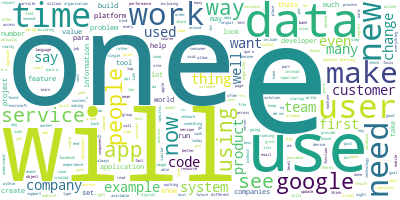

In [20]:
# Create a wordcloud of trimmed.text_no_punc_lower
long_string = ','.join(trimmed.text_no_punc_lower)
wc = WordCloud(background_color="white", max_words=5000, contour_width=5, contour_color='steelblue')
wc.generate(long_string)
wc.to_image()

#### Prepare the data for LDA

In [21]:
%pip install gensim

Note: you may need to restart the kernel to use updated packages.


In [22]:
import gensim
from gensim.utils import simple_preprocess

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ksrs9\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [23]:
stopwords_en = stopwords.words('english')

In [24]:
# Define a function to convert sentences to words using gensim's simple_preprocess
def sentences_to_words(sentences):
    for sentence in sentences:
        yield(simple_preprocess(str(sentence), deacc=True))

# define a function to remove stopwords
def remove_stopwords(words):
    return [w for w in words if w not in stopwords_en]

In [25]:
sentences = trimmed.text_description.values.tolist()

In [26]:
words_array = list(sentences_to_words(sentences))

In [27]:
words_array[0]

['all',
 'of',
 'this',
 'work',
 'is',
 'still',
 'very',
 'early',
 'the',
 'first',
 'full',
 'public',
 'version',
 'of',
 'the',
 'ethereum',
 'software',
 'was',
 'recently',
 'released',
 'and',
 'the',
 'system',
 'could',
 'face',
 'some',
 'of',
 'the',
 'same',
 'technical',
 'and',
 'legal',
 'problems',
 'that',
 'have',
 'tarnished',
 'bitcoin',
 'many',
 'bitcoin',
 'advocates',
 'say',
 'ethereum',
 'will',
 'face',
 'more',
 'security',
 'problems',
 'than',
 'bitcoin',
 'because',
 'of',
 'the',
 'greater',
 'complexity',
 'of',
 'the',
 'software',
 'thus',
 'far',
 'ethereum',
 'has',
 'faced',
 'much',
 'less',
 'testing',
 'and',
 'many',
 'fewer',
 'attacks',
 'than',
 'bitcoin',
 'the',
 'novel',
 'design',
 'of',
 'ethereum',
 'may',
 'also',
 'invite',
 'intense',
 'scrutiny',
 'by',
 'authorities',
 'given',
 'that',
 'potentially',
 'fraudulent',
 'contracts',
 'like',
 'the',
 'ponzi',
 'schemes',
 'can',
 'be',
 'written',
 'directly',
 'into',
 'the',
 'e

In [28]:
no_stopwords = [remove_stopwords(words) for words in words_array]

In [29]:
no_stopwords[0]

['work',
 'still',
 'early',
 'first',
 'full',
 'public',
 'version',
 'ethereum',
 'software',
 'recently',
 'released',
 'system',
 'could',
 'face',
 'technical',
 'legal',
 'problems',
 'tarnished',
 'bitcoin',
 'many',
 'bitcoin',
 'advocates',
 'say',
 'ethereum',
 'face',
 'security',
 'problems',
 'bitcoin',
 'greater',
 'complexity',
 'software',
 'thus',
 'far',
 'ethereum',
 'faced',
 'much',
 'less',
 'testing',
 'many',
 'fewer',
 'attacks',
 'bitcoin',
 'novel',
 'design',
 'ethereum',
 'may',
 'also',
 'invite',
 'intense',
 'scrutiny',
 'authorities',
 'given',
 'potentially',
 'fraudulent',
 'contracts',
 'like',
 'ponzi',
 'schemes',
 'written',
 'directly',
 'ethereum',
 'system',
 'sophisticated',
 'capabilities',
 'system',
 'made',
 'fascinating',
 'executives',
 'corporate',
 'america',
 'ibm',
 'said',
 'last',
 'year',
 'experimenting',
 'ethereum',
 'way',
 'control',
 'real',
 'world',
 'objects',
 'called',
 'internet',
 'things',
 'microsoft',
 'working',


Build a Dictionary

In [30]:
from gensim.corpora import Dictionary

data_dictionary = Dictionary(no_stopwords)
corpus = [data_dictionary.doc2bow(word_arr) for word_arr in no_stopwords]

In [31]:
# data_dictionary.doc2bow(words[0])
# len(words[0])
# words[0][13]

In [32]:
# corpus[0]

In [33]:
num_topics = 10

In [34]:
lda_model = gensim.models.ldamodel.LdaModel(
    corpus=corpus, 
    id2word=data_dictionary, 
    num_topics=num_topics, 
    random_state=42, 
    update_every=1, 
    chunksize=100, 
    passes=10, 
    alpha='auto', 
    eta='auto',
    per_word_topics=True
)

In [35]:
from pprint import pprint
pprint(lda_model.print_topics())

[(0,
  '0.012*"new" + 0.008*"customer" + 0.008*"company" + 0.008*"companies" + '
  '0.008*"digital" + 0.007*"year" + 0.007*"business" + 0.007*"technology" + '
  '0.007*"customers" + 0.005*"services"'),
 (1,
  '0.003*"sha" + 0.002*"encrypt" + 0.001*"requesting" + 0.000*"decrypt" + '
  '0.000*"cipher" + 0.000*"prng" + 0.000*"cracking" + 0.000*"jjwt" + '
  '0.000*"bcrypt" + 0.000*"panther"'),
 (2,
  '0.012*"code" + 0.011*"use" + 0.007*"using" + 0.006*"api" + 0.005*"drupal" + '
  '0.005*"data" + 0.005*"also" + 0.005*"need" + 0.005*"example" + '
  '0.005*"java"'),
 (3,
  '0.030*"aws" + 0.017*"network" + 0.011*"ip" + 0.009*"http" + 0.009*"load" + '
  '0.008*"address" + 0.008*"instances" + 0.008*"vpc" + 0.008*"traffic" + '
  '0.008*"ec"'),
 (4,
  '0.010*"one" + 0.010*"time" + 0.008*"people" + 0.008*"like" + 0.008*"work" + '
  '0.008*"team" + 0.006*"way" + 0.006*"make" + 0.006*"get" + 0.005*"would"'),
 (5,
  '0.029*"app" + 0.025*"google" + 0.018*"android" + 0.016*"apple" + '
  '0.015*"users" +

In [36]:
doc_lda = lda_model[corpus]

Evaluation

In [37]:
lda_model.log_perplexity(corpus)

-9.133969859267198

In [38]:
doc_lda

In [39]:
doc_lda[0]

([(0, 0.5967025),
  (2, 0.06046356),
  (4, 0.24995418),
  (8, 0.0764533),
  (9, 0.01589272)],
 [(0, [4, 2]),
  (1, [0, 2]),
  (2, [0, 4]),
  (3, [0]),
  (4, [0, 4]),
  (5, [0, 8, 2]),
  (6, [0, 2, 8, 4]),
  (7, [0, 4, 2, 8]),
  (8, [2]),
  (9, [0, 9]),
  (10, [4, 0, 2, 8]),
  (11, [2, 0, 8]),
  (12, [0, 8, 2]),
  (13, [0, 4, 8, 2]),
  (14, [0, 4, 2, 8]),
  (15, [8, 0, 4]),
  (16, [0]),
  (17, [2]),
  (18, [0]),
  (19, [0, 4]),
  (20, [8, 2]),
  (21, [8, 0]),
  (22, [0]),
  (23, [0, 8, 4, 2]),
  (24, [4, 2, 8, 0]),
  (25, [4, 0, 8, 2]),
  (26, [0, 4]),
  (27, [0, 8]),
  (28, [2]),
  (29, [0]),
  (30, [0]),
  (31, [0]),
  (32, [4, 9]),
  (33, []),
  (34, [0, 4, 8]),
  (35, [0]),
  (36, [0, 4]),
  (37, [4, 0, 2, 8]),
  (38, [0, 4, 8, 2]),
  (39, []),
  (40, [0, 4]),
  (41, [0]),
  (42, [0]),
  (43, [0, 4, 8, 2, 9]),
  (44, [4, 0, 8, 9]),
  (45, [0]),
  (46, [0, 8, 2]),
  (47, [4, 8]),
  (48, [0]),
  (49, [0, 2]),
  (50, [4, 0, 8]),
  (51, [8, 0]),
  (52, [8]),
  (53, [0, 8, 4]),
  (54, [4

In [40]:
lda_model.get_document_topics(corpus[0], minimum_probability=0.01)

[(0, 0.5967034),
 (2, 0.06046782),
 (4, 0.24995343),
 (8, 0.07644856),
 (9, 0.015893029)]

In [41]:
lda_model.show_topic(0)

[('new', 0.011757157),
 ('customer', 0.008443463),
 ('company', 0.008397211),
 ('companies', 0.008081194),
 ('digital', 0.0078710895),
 ('year', 0.0071024876),
 ('business', 0.0070922845),
 ('technology', 0.007092002),
 ('customers', 0.007069505),
 ('services', 0.004711236)]

In [42]:
all_topics = lda_model.get_document_topics(corpus, minimum_probability=0.01)

In [43]:
all_topics_matrix = gensim.matutils.corpus2csc(all_topics)

In [44]:
all_topics_matrix

<10x3026 sparse matrix of type '<class 'numpy.float64'>'
	with 12147 stored elements in Compressed Sparse Column format>

Matrix is 10 X 3026, meaning it has one row for each topic, and one column for each item.

So take the transpose

In [45]:
all_topics_arr = all_topics_matrix.T.toarray()

In [46]:
all_topics_df = pd.DataFrame(all_topics_arr)

In [47]:
all_topics_df.head()

,0,1,2,3,4,5,6,7,8,9
0,0.596703,0.0,0.060467,0.0,0.249953,0.000000,0.0,0.000000,0.076450,0.015893
1,0.550480,0.0,0.167533,0.0,0.160298,0.012405,0.0,0.011138,0.097233,0.000000
2,0.011917,0.0,0.039900,0.0,0.369743,0.279318,0.0,0.000000,0.297406,0.000000
3,0.532292,0.0,0.053922,0.0,0.347219,0.014003,0.0,0.000000,0.047611,0.000000
4,0.727618,0.0,0.000000,0.0,0.078933,0.000000,0.0,0.000000,0.182870,0.000000


In [48]:
all_topics_df[1].value_counts()

0.000000    3022
0.034153       1
0.053826       1
0.013496       1
0.025020       1
Name: 1, dtype: int64

Squashing the topics into a single list

In [49]:
for idx, row in enumerate(lda_model[corpus]):
    print(idx, row)
    row = sorted(row, key=lambda x: (x[1]), reverse=True)
    print(row)

    # Extract the first item from each tuple in row
    topic_indices = [x[0] for x in row]

    # print(lda_model.show_topic(row[0][0]))
    print(topic_indices)
    break

0 [(0, 0.5967023), (2, 0.06046574), (4, 0.24995317), (8, 0.07645205), (9, 0.015893007)]
[(0, 0.5967023), (4, 0.24995317), (8, 0.07645205), (2, 0.06046574), (9, 0.015893007)]
[0, 4, 8, 2, 9]


In [50]:
def get_topic_indices(row):
    row = sorted(row, key=lambda x: (x[1]), reverse=True)
    topic_indices = [x[0] for x in row]
    return topic_indices

In [51]:
# Map the get_topic_indices function to lda_model[corpus]
topic_indices = list(map(get_topic_indices, lda_model[corpus]))

In [52]:
topic_indices[0]

[0, 4, 8, 2, 9]

In [53]:
# Convert topic_indices to a Series, and convert the Series into a DataFrame
topic_indices_df = pd.DataFrame(pd.Series(topic_indices))

In [54]:
topic_indices_df.head()

,0
0,"[0, 4, 8, 2, 9]"
1,"[0, 2, 4, 8, 5, 7]"
2,"[4, 8, 5, 2, 0]"
3,"[0, 4, 2, 8, 5]"
4,"[0, 8, 4]"


In [55]:
# Concatenate trimmed and topic_indices_df
trimmed_topics = pd.concat([trimmed, topic_indices_df], axis=1)

In [56]:
trimmed_topics.head()

,title,text_description,interaction_type,text_no_punc,text_no_punc_lower,0
0,"Ethereum, a Virtual Currency, Enables Transact...",All of this work is still very early. The firs...,content_present,All of this work is still very early The first...,all of this work is still very early the first...,"[0, 4, 8, 2, 9]"
1,Bitcoin Future: When GBPcoin of Branson Wins O...,The alarm clock wakes me at 8:00 with stream o...,content_present,The alarm clock wakes me at 800 with stream of...,the alarm clock wakes me at 800 with stream of...,"[0, 2, 4, 8, 5, 7]"
2,Google Data Center 360° Tour,We're excited to share the Google Data Center ...,content_present,Were excited to share the Google Data Center 3...,were excited to share the google data center 3...,"[4, 8, 5, 2, 0]"
3,"IBM Wants to ""Evolve the Internet"" With Blockc...",The Aite Group projects the blockchain market ...,content_present,The Aite Group projects the blockchain market ...,the aite group projects the blockchain market ...,"[0, 4, 2, 8, 5]"
4,IEEE to Talk Blockchain at Cloud Computing Oxf...,One of the largest and oldest organizations fo...,content_present,One of the largest and oldest organizations fo...,one of the largest and oldest organizations fo...,"[0, 8, 4]"


In [57]:
# Rename the column in trimmed_topics
trimmed_topics = trimmed_topics.rename(columns={0: 'topic_indices'})

In [58]:
trimmed_topics.head()

,title,text_description,interaction_type,text_no_punc,text_no_punc_lower,topic_indices
0,"Ethereum, a Virtual Currency, Enables Transact...",All of this work is still very early. The firs...,content_present,All of this work is still very early The first...,all of this work is still very early the first...,"[0, 4, 8, 2, 9]"
1,Bitcoin Future: When GBPcoin of Branson Wins O...,The alarm clock wakes me at 8:00 with stream o...,content_present,The alarm clock wakes me at 800 with stream of...,the alarm clock wakes me at 800 with stream of...,"[0, 2, 4, 8, 5, 7]"
2,Google Data Center 360° Tour,We're excited to share the Google Data Center ...,content_present,Were excited to share the Google Data Center 3...,were excited to share the google data center 3...,"[4, 8, 5, 2, 0]"
3,"IBM Wants to ""Evolve the Internet"" With Blockc...",The Aite Group projects the blockchain market ...,content_present,The Aite Group projects the blockchain market ...,the aite group projects the blockchain market ...,"[0, 4, 2, 8, 5]"
4,IEEE to Talk Blockchain at Cloud Computing Oxf...,One of the largest and oldest organizations fo...,content_present,One of the largest and oldest organizations fo...,one of the largest and oldest organizations fo...,"[0, 8, 4]"


In [59]:
lda_model.print_topics()

[(0,
  '0.012*"new" + 0.008*"customer" + 0.008*"company" + 0.008*"companies" + 0.008*"digital" + 0.007*"year" + 0.007*"business" + 0.007*"technology" + 0.007*"customers" + 0.005*"services"'),
 (1,
  '0.003*"sha" + 0.002*"encrypt" + 0.001*"requesting" + 0.000*"decrypt" + 0.000*"cipher" + 0.000*"prng" + 0.000*"cracking" + 0.000*"jjwt" + 0.000*"bcrypt" + 0.000*"panther"'),
 (2,
  '0.012*"code" + 0.011*"use" + 0.007*"using" + 0.006*"api" + 0.005*"drupal" + 0.005*"data" + 0.005*"also" + 0.005*"need" + 0.005*"example" + 0.005*"java"'),
 (3,
  '0.030*"aws" + 0.017*"network" + 0.011*"ip" + 0.009*"http" + 0.009*"load" + 0.008*"address" + 0.008*"instances" + 0.008*"vpc" + 0.008*"traffic" + 0.008*"ec"'),
 (4,
  '0.010*"one" + 0.010*"time" + 0.008*"people" + 0.008*"like" + 0.008*"work" + 0.008*"team" + 0.006*"way" + 0.006*"make" + 0.006*"get" + 0.005*"would"'),
 (5,
  '0.029*"app" + 0.025*"google" + 0.018*"android" + 0.016*"apple" + 0.015*"users" + 0.013*"apps" + 0.013*"facebook" + 0.012*"mobile" 

In [60]:
def get_topic_names_from_index(idx):
    if idx == 0:
        return ['Customer Service', 'Technology', 'Business']
    if idx == 1:
        return ['Encryption', 'Technology', 'Digital Security', 'Computer Science']
    if idx == 2:
        return ['Programming', 'API', 'Java', 'Technology']
    if idx == 3:
        return ['Cloud', 'AWS', 'Amazon Web Services', 'Internet', 'Technology']
    if idx == 4:
        return ['Teams', 'People', 'Office']
    if idx == 5:
        return ['Mobiles', 'Technology', 'Android', 'IOS', 'Apple', 'Google']
    if idx == 6:
        return ['Cloud', 'AWS', 'Amazon Web Services', 'Internet']
    if idx == 7:
        return ['Cloud', 'AWS', 'Amazon Web Services', 'Internet']
    if idx == 8:
        return ['Cloud', 'AWS', 'Amazon Web Services', 'Internet']
    if idx == 9:
        return ['Cloud', 'AWS', 'Amazon Web Services', 'Internet']
    return []

def get_topic_names(row):
    topic_names = [get_topic_names_from_index(idx) for idx in row]
    flat = [item for sublist in topic_names for item in sublist]
    return list(set(flat))

In [61]:
# Drop text_no_punc and text_no_punc_lower from trimmed_topics
trimmed_topics = trimmed_topics.drop(['text_no_punc', 'text_no_punc_lower'], axis=1)

In [62]:
trimmed_topics.head()

,title,text_description,interaction_type,topic_indices
0,"Ethereum, a Virtual Currency, Enables Transact...",All of this work is still very early. The firs...,content_present,"[0, 4, 8, 2, 9]"
1,Bitcoin Future: When GBPcoin of Branson Wins O...,The alarm clock wakes me at 8:00 with stream o...,content_present,"[0, 2, 4, 8, 5, 7]"
2,Google Data Center 360° Tour,We're excited to share the Google Data Center ...,content_present,"[4, 8, 5, 2, 0]"
3,"IBM Wants to ""Evolve the Internet"" With Blockc...",The Aite Group projects the blockchain market ...,content_present,"[0, 4, 2, 8, 5]"
4,IEEE to Talk Blockchain at Cloud Computing Oxf...,One of the largest and oldest organizations fo...,content_present,"[0, 8, 4]"


In [63]:
# Iterate over the topic_indices column in trimmed_topics and apply get_topic_names_from_index
trimmed_topics['topic_names'] = trimmed_topics['topic_indices'].apply(lambda x: get_topic_names(x))

In [64]:
trimmed_topics.head()

,title,text_description,interaction_type,topic_indices,topic_names
0,"Ethereum, a Virtual Currency, Enables Transact...",All of this work is still very early. The firs...,content_present,"[0, 4, 8, 2, 9]","[Technology, Cloud, Java, Business, Customer S..."
1,Bitcoin Future: When GBPcoin of Branson Wins O...,The alarm clock wakes me at 8:00 with stream o...,content_present,"[0, 2, 4, 8, 5, 7]","[Technology, Cloud, Java, Mobiles, Business, C..."
2,Google Data Center 360° Tour,We're excited to share the Google Data Center ...,content_present,"[4, 8, 5, 2, 0]","[Mobiles, Cloud, Technology, Java, Apple, Cust..."
3,"IBM Wants to ""Evolve the Internet"" With Blockc...",The Aite Group projects the blockchain market ...,content_present,"[0, 4, 2, 8, 5]","[Technology, Cloud, Java, Mobiles, Business, C..."
4,IEEE to Talk Blockchain at Cloud Computing Oxf...,One of the largest and oldest organizations fo...,content_present,"[0, 8, 4]","[Technology, Cloud, Business, Customer Service..."


In [65]:
# Drop topic_indices from trimmed_topics
trimmed_topics = trimmed_topics.drop('topic_indices', axis=1)

In [66]:
trimmed_topics.head()

,title,text_description,interaction_type,topic_names
0,"Ethereum, a Virtual Currency, Enables Transact...",All of this work is still very early. The firs...,content_present,"[Technology, Cloud, Java, Business, Customer S..."
1,Bitcoin Future: When GBPcoin of Branson Wins O...,The alarm clock wakes me at 8:00 with stream o...,content_present,"[Technology, Cloud, Java, Mobiles, Business, C..."
2,Google Data Center 360° Tour,We're excited to share the Google Data Center ...,content_present,"[Mobiles, Cloud, Technology, Java, Apple, Cust..."
3,"IBM Wants to ""Evolve the Internet"" With Blockc...",The Aite Group projects the blockchain market ...,content_present,"[Technology, Cloud, Java, Mobiles, Business, C..."
4,IEEE to Talk Blockchain at Cloud Computing Oxf...,One of the largest and oldest organizations fo...,content_present,"[Technology, Cloud, Business, Customer Service..."


In [67]:
trimmed_topics['topic_names']

0       [Technology, Cloud, Java, Business, Customer S...
1       [Technology, Cloud, Java, Mobiles, Business, C...
2       [Mobiles, Cloud, Technology, Java, Apple, Cust...
3       [Technology, Cloud, Java, Mobiles, Business, C...
4       [Technology, Cloud, Business, Customer Service...
                              ...                        
3021          [AWS, Cloud, Amazon Web Services, Internet]
3022    [Mobiles, Technology, Cloud, Java, Apple, Cust...
3023    [Technology, Cloud, Java, Business, Customer S...
3024    [Technology, Cloud, Java, Mobiles, Business, C...
3025    [Technology, Java, Business, Customer Service,...
Name: topic_names, Length: 3026, dtype: object

In [68]:
# Add the topic_names column to content
content = pd.concat([content, trimmed_topics['topic_names']], axis=1)

In [69]:
content.head()

,index,event_timestamp,interaction_type,item_id,producer_id,producer_session_id,producer_device_info,producer_location,producer_country,item_type,item_url,title,text_description,language,topic_names
0,1,1459193988,content_present,-4110354420726924665,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,http://www.nytimes.com/2016/03/28/business/dea...,"Ethereum, a Virtual Currency, Enables Transact...",All of this work is still very early. The firs...,en,"[Technology, Cloud, Java, Business, Customer S..."
1,2,1459194146,content_present,-7292285110016212249,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,http://cointelegraph.com/news/bitcoin-future-w...,Bitcoin Future: When GBPcoin of Branson Wins O...,The alarm clock wakes me at 8:00 with stream o...,en,"[Technology, Cloud, Java, Mobiles, Business, C..."
2,3,1459194474,content_present,-6151852268067518688,3891637997717104548,-1457532940883382585,NaN,NaN,NaN,HTML,https://cloudplatform.googleblog.com/2016/03/G...,Google Data Center 360° Tour,We're excited to share the Google Data Center ...,en,"[Mobiles, Cloud, Technology, Java, Apple, Cust..."
3,4,1459194497,content_present,2448026894306402386,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,https://bitcoinmagazine.com/articles/ibm-wants...,"IBM Wants to ""Evolve the Internet"" With Blockc...",The Aite Group projects the blockchain market ...,en,"[Technology, Cloud, Java, Mobiles, Business, C..."
4,5,1459194522,content_present,-2826566343807132236,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,http://www.coindesk.com/ieee-blockchain-oxford...,IEEE to Talk Blockchain at Cloud Computing Oxf...,One of the largest and oldest organizations fo...,en,"[Technology, Cloud, Business, Customer Service..."


In [ ]:
trimmed.shape

In [ ]:
y.shape

In [ ]:
# x.columns

In [ ]:
trimmed.shape

In [ ]:
dups = trimmed[trimmed.duplicated(subset=['title', 'text_description'])]

In [ ]:
dups.head(20)